# Experiment Analysis

This notebook loads the (anonymized) human data from the behavioral experiment and analyzes it.

In [1]:
import copy
import hashlib
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pylab as plt

%load_ext autoreload
%autoreload 2

## Load data and unpack conditions, etc

In [2]:
trials = pd.read_csv("final_exp_human_trials.csv")
questions = pd.read_csv("final_human_exp_questions.csv")

In [3]:
# Sanity check randomizations

if False:
    print("\nLog message counts:")
    print(questions.key.value_counts())
    
    print("\nFull condition messages:")
    print(questions[questions.key == "condition"].value.value_counts())
    
    print("\nTrial data files used:")
    print(questions[questions.key == "trialDataFile"].value.value_counts())

    print("\nFeature randomizations:")
    feature_randomizations = questions[questions.key == "featureRandomization"].value
    feature_randomizations = feature_randomizations.apply(lambda x: json.loads(x))
    feature_randomizations = pd.DataFrame(list(feature_randomizations.values))
    for feature in ["Green", "Red", "Blue", "Spotted", "Solid", "Striped"]:
        print(feature_randomizations[feature].value_counts())

## Read in trial data

In [4]:
# Load data, filter out debug, hash ID

# Read JSON data into Python objects
trials["data"] = trials.value.apply(lambda x: json.loads(x))

for field in ["rt", "trial_type"]:
    trials[field] = trials.data.apply(lambda x: x.get(field))
    
trials.trial_type.value_counts()

survey-html-form        3780
html-button-response    1143
survey-likert            607
instructions             231
survey-multi-choice      186
survey-text              105
Name: trial_type, dtype: int64

In [5]:
print("Pre-Quiz Count: {} participants.".format(trials.workerid.nunique()))

Pre-Quiz Count: 119 participants.


# Experiment Duration

count    119.000000
mean      18.525471
std        7.624343
min        3.082400
25%       12.996092
50%       17.425250
75%       22.826625
max       41.320933
Name: time_elapsed, dtype: float64

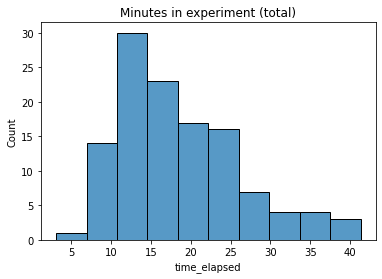

In [6]:
trials["time_elapsed"] = trials.data.apply(lambda x: x.get("time_elapsed"))
minutes_in_experiment = trials.groupby("workerid").time_elapsed.max() / 1000 / 60

sns.histplot(minutes_in_experiment, bins=10)
plt.title("Minutes in experiment (total)")

minutes_in_experiment.describe()

## Quiz
How many attempts do people take?
What fraction pass?
Which pages are "hardest"?

In [7]:
quizResults = questions[questions.key.str.contains('quizPassed') | questions.key.str.contains('quizFailed')]
quizResults["passed_quiz"] = quizResults.key.apply(lambda x: True if x == "quizPassed" else False)

quizResults = quizResults[["workerid", "passed_quiz"]].set_index("workerid")

quizResults.passed_quiz.value_counts()

/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_60670/1755126429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quizResults["passed_quiz"] = quizResults.key.apply(lambda x: True if x == "quizPassed" else False)


True     104
False     14
Name: passed_quiz, dtype: int64

In [8]:
quizAttempts = questions[questions.key.str.contains('quizAttempt')]
quizAttempts = quizAttempts[quizAttempts.workerid.isin(trials.workerid.unique())]

quizAttempts["data"] = quizAttempts.value.apply(lambda x: json.loads(x))
quizAttempts["correct"] = quizAttempts["data"].apply(lambda x: x["correct"])
quizAttempts["total"] = quizAttempts["data"].apply(lambda x: x["total"])
quizAttempts["cum_correct"] = quizAttempts["correct"] + 14 - quizAttempts["total"]
quizAttempts["passed"] = quizAttempts["data"].apply(lambda x: x["total"] == x["correct"])

if False:
    quizAttempts.groupby("key").cum_correct.agg(["size", "mean", "std"])

In [9]:
participant_quiz_results = quizAttempts.groupby("workerid").size()

trials = trials.set_index("workerid").merge(participant_quiz_results.to_frame(name="quiz_attempts"), left_index=True, right_index=True, how="left").reset_index()

In [10]:
quiz_trials = trials[trials.data.apply(lambda x: x.get("total") is not None)]

quiz_trials["total"] = quiz_trials.data.apply(lambda x: int(x.get("total")))
quiz_trials["correct"] = quiz_trials.data.apply(lambda x: int(x.get("correct")))
quiz_trials["wrong"] = quiz_trials.total - quiz_trials.correct

quiz_trials["response"] = quiz_trials.data.apply(lambda x: x.get("response"))

quiz_trials["first_attempt"] = quiz_trials.num <= 12
wrong_answers = quiz_trials[quiz_trials.wrong >=1]

/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_60670/3177066139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quiz_trials["total"] = quiz_trials.data.apply(lambda x: int(x.get("total")))
/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_60670/3177066139.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quiz_trials["correct"] = quiz_trials.data.apply(lambda x: int(x.get("correct")))
/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_60670/3177066139.py:5: SettingWithCopyW

## Exit Survey

In [11]:
exit_survey = trials[trials.trial_type == 'survey-text']

In [12]:
for question in ["experiment_objective", "participant_strategy", "experiment_confusing", "misc_feedback"]:
    exit_survey[question] = exit_survey.data.apply(lambda x: x["response"][question])

print("Experiment Objective:\n")
print(exit_survey.experiment_objective.values)

print("\nParticipant Strategies:\n")
print(exit_survey.participant_strategy.values)

print("\nAnything Confusing:\n")
print(exit_survey.experiment_confusing.values)

print("\nMisc Feedback:\n")
print(exit_survey.misc_feedback.values)

Experiment Objective:

['to ensure tourists chose tasty mushrooms'
 'to provide them with the knowledge of the tatsiest mushrooms'
 'To get them as many tasty mushrooms as possible'
 'For tourists to collect the tastiest mushrooms possible each time.'
 'maximise the score' 'To get them the best'
 'Get them to pick the best mushrooms'
 'TO DIRECT PEOPLE TO THE MOST ENJOYYABLE TO EAT'
 'to help them work out the tasty mushrooms'
 'to help them pick the best mushroom' 'select good tasting mushrooms'
 'To make sure that the tourists picked the highest value mushrooms.'
 'To help them pick good mushrooms.'
 'To get teh highest possible taste in mushrooms for the people'
 'To get the tourists to pick the tastiest mushrooms'
 'Help the tourists chose the tastiest mushrooms'
 'To make help the tourist pick the tastiest mushroom'
 'to inform tourists about mushrooms'
 'give out the best flavours to attract more tourists'
 'To give the customer the best tasting mushroom'
 'To teach them to avoid

/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_60670/1776341517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_survey[question] = exit_survey.data.apply(lambda x: x["response"][question])
/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_60670/1776341517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_survey[question] = exit_survey.data.apply(lambda x: x["response"][question])
/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_60670/1776341517.py:2: SettingWit

# Catch Trials
Do people get these right?  
What is % correct by person?   
By context / question? (are some harder than others?)

In [13]:
select_trials = trials[trials.trial_type == 'survey-html-form']
catch_trials = select_trials[select_trials['data'].apply(lambda x: bool(x.get('features', 'all') != 'all'))]

catch_trials["belief_model"] = catch_trials.data.apply(lambda x: 1 if x.get("belief") else 0)
catch_trials["response"] = catch_trials.data.apply(lambda x: bool(int(x['response']["utterance"])))
catch_trials["catch_trial_correct"] = catch_trials["belief_model"] == catch_trials["response"]

catch_trials["feature"] = catch_trials.data.apply(lambda x: x.get("features")[0])
catch_trials["feature_value"] = catch_trials.data.apply(lambda x: x.get("values")[0])

# Grab only the first action context, so multi-horizon participants join correctly
catch_trials["action_context"] = catch_trials.data.apply(lambda x: str([x.get("action_context")[0]]))

catch_trials["action_context"] = catch_trials.data.apply(lambda x: str(x.get("action_context")))
# catch_trials["context_hash"] = catch_trials.action_context.apply(hash_id)

/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_60670/3387171192.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catch_trials["belief_model"] = catch_trials.data.apply(lambda x: 1 if x.get("belief") else 0)
/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_60670/3387171192.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catch_trials["response"] = catch_trials.data.apply(lambda x: bool(int(x['response']["utterance"])))
/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_606

Text(0, 0.5, 'Fraction of participants')

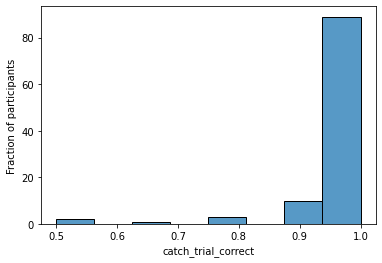

In [14]:
participant_catch_results = catch_trials[["catch_trial_correct",  "workerid"]].groupby(["workerid"]).mean().reset_index()
participant_catch_results["passed_catch_trial"] = participant_catch_results.catch_trial_correct > .75

sns.histplot(participant_catch_results, x="catch_trial_correct", multiple="dodge")
plt.ylabel("Fraction of participants")

In [15]:
# Join catch results into main dataframe to simplify analysis
joined_trials = trials.set_index("workerid").join(participant_catch_results[["passed_catch_trial", "catch_trial_correct", "workerid"]].set_index('workerid'))

joined_trials = joined_trials.join(quizResults).reset_index()

joined_trials.passed_catch_trial = joined_trials.passed_catch_trial.fillna(False)
joined_trials["no_catch_data"] = joined_trials.passed_catch_trial.isnull()

In [16]:
print("{} unique workers before join, {} after.".format(trials.workerid.nunique(), joined_trials.workerid.nunique()))

# joined_trials.groupby(["objective", "horizon", "passed_catch_trial"]).workerid.nunique()

119 unique workers before join, 119 after.


In [17]:
joined_trials.groupby(["passed_quiz", "passed_catch_trial"]).workerid.nunique()

passed_quiz  passed_catch_trial
False        False                 14
True         False                  5
             True                  99
Name: workerid, dtype: int64

## Drop participants that did not pass

In [18]:
joined_trials = joined_trials[joined_trials.passed_catch_trial]

## Visualize Responses

In [19]:
select_trials = joined_trials[joined_trials.trial_type == 'survey-html-form']

exp1_trials = select_trials[select_trials["data"].apply(lambda x: x.get("features", "all") == "all")]

len(exp1_trials)

2772

In [20]:
exp1_trials.data.iloc[1]["response"]

{'feature': 'Green', 'feature_value': '2', 'texture': '', 'color': ''}

In [21]:
exp1_trials["feature"] = exp1_trials.data.apply(lambda x: x["response"]["feature"])
exp1_trials["feature_value"] = exp1_trials.data.apply(lambda x: x["response"]["feature_value"])
exp1_trials["instruction_texture"] = exp1_trials.data.apply(lambda x: x["response"]["texture"])
exp1_trials["instruction_color"] = exp1_trials.data.apply(lambda x: x["response"]["color"])
exp1_trials["horizon"] = exp1_trials.data.apply(lambda x: int(x["horizon"]))

exp1_trials["utterance"] = exp1_trials.data.apply(lambda x: x["response"])

exp1_trials["instruction"] = exp1_trials.data.apply(lambda x: (x["response"]["feature"]) == "")

exp1_trials["feature_value"] = exp1_trials.apply(lambda x: int(x["feature_value"]) if not x["instruction"] else None, axis=1)

# Sanity check chosen messages
exp1_trials.feature.value_counts()

/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_60670/3512373998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp1_trials["feature"] = exp1_trials.data.apply(lambda x: x["response"]["feature"])
/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_60670/3512373998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp1_trials["feature_value"] = exp1_trials.data.apply(lambda x: x["response"]["feature_value"])
/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_60670/3512373998.

           1203
Green       860
Blue        389
Spotted     213
Striped     107
Name: feature, dtype: int64

In [22]:
def align_instructions(row):
    
    if not row["instruction"]:
        return row
    
    # Is this row aligned already? If so, return
    if row["instruction_texture"] in ["Spotted", "Solid", "Striped"]:
        return row
    
    # Otherwise, switch 'em
    row_color = row["instruction_texture"]
    row["instruction_texture"] = row["instruction_color"]
    row["instruction_color"] = row_color
        
    return row

exp1_trials = exp1_trials.apply(align_instructions, axis=1)## Visualize Responses

In [23]:
exp1_trials["message_type"] = exp1_trials.instruction.apply(lambda x: "Instructions" if x else "Descriptions")

n_instructions = exp1_trials[exp1_trials["message_type"] == "Instructions"].workerid.value_counts()

In [24]:
n_instructions = exp1_trials[exp1_trials["message_type"] == "Instructions"].workerid.value_counts()

exp1_joined = pd.merge(exp1_trials, n_instructions.to_frame(name="n_instructions"), 
                       left_on='workerid', right_index=True, how='left').reset_index()

exp1_joined["n_instructions"].fillna(0, inplace=True)

exp1_trials = exp1_joined

Text(0, 0.5, 'Message Count')

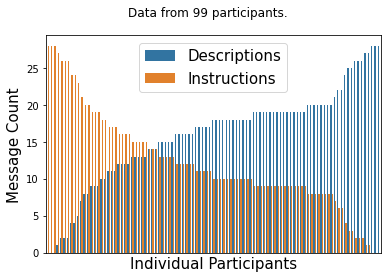

In [25]:
ordering = exp1_trials.drop_duplicates(["workerid", "n_instructions"]).sort_values("n_instructions", ascending=False).workerid

sns.countplot(data=exp1_trials, x="workerid", hue="message_type", order=ordering, hue_order=["Descriptions", "Instructions"])
plt.suptitle("Data from {} participants.".format(exp1_trials.workerid.nunique()))
plt.xticks([])
plt.xlabel("Individual Participants", fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.ylabel("Message Count", fontsize=15)


In [26]:
exp1_trials[exp1_trials.n_instructions.isin([0, 28])].workerid.nunique()

6

In [27]:
count_by_horizon = exp1_trials.groupby(["horizon", "message_type"]).size().reset_index()
count_by_horizon = count_by_horizon.rename({0:"size"}, axis=1)

count_by_horizon["pct"] = count_by_horizon.groupby("horizon")["size"].transform(lambda x: x/x.sum())
# count_by_horizon.size()#.transform(lambda x: x / x.sum())
# mean_by_horizon = exp1_trials

Text(0.5, 0, 'Speaker Horizon $H$')

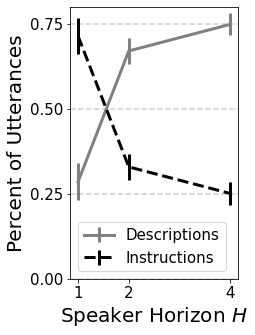

In [28]:
import math

descriptions = count_by_horizon[count_by_horizon.message_type == "Descriptions"]
instructions = count_by_horizon[count_by_horizon.message_type != "Descriptions"]

# plt.plot(instructions.horizon, instructions.pct, c='black', linewidth = 5)
# plt.plot(descriptions.horizon, descriptions.pct, c='black', linewidth = 5)

description_err = descriptions.apply(lambda x: 1.96 * math.sqrt(x['pct']*(1-x['pct'])/x['size']), axis=1)
# instruction_err = instructions.apply(lambda x: 1.96 * math.sqrt(x['pct']*(1-x['pct'])/x['size']), axis=1)

plt.figure(figsize=(3,5))
ax = plt.gca()
ax.errorbar(descriptions.horizon, descriptions.pct, description_err,  color='gray', ecolor='gray',  linewidth=3, label="Descriptions")
ax.errorbar(instructions.horizon, instructions.pct, description_err,  color='k', ecolor='k', linewidth=3, linestyle='--', label="Instructions")

plt.legend(loc='best', fontsize=15)
ax.set_ylim(0, .8)
plt.xticks([1, 2, 4], fontsize=15)
ys = [0, .25, .5, .75]
for y in ys:
    plt.axhline(y, alpha=.2, linestyle='--', c='k', zorder=0)
plt.yticks(ys, fontsize=15);

plt.ylabel("Percent of Utterances", fontsize=20)
plt.xlabel("Speaker Horizon $H$", fontsize=20)

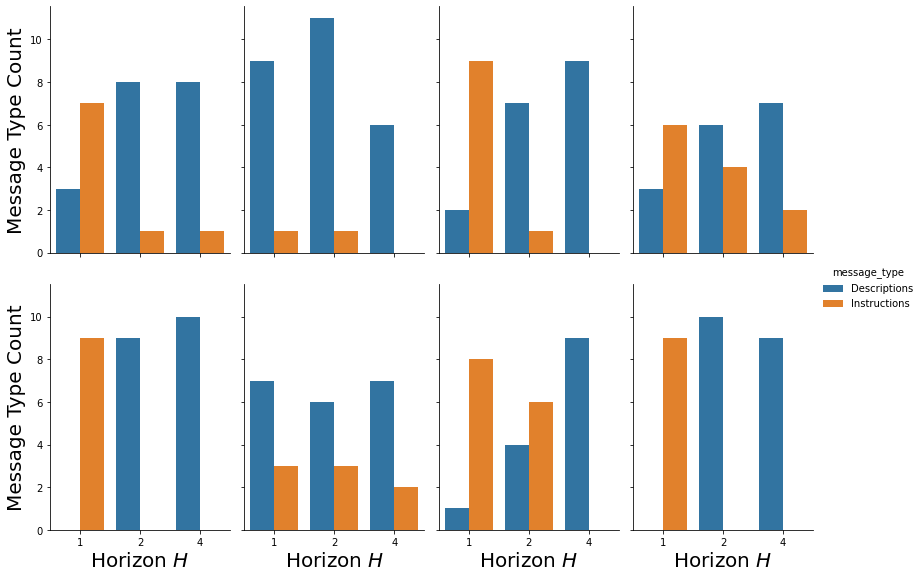

In [29]:
random_ids = exp1_trials.workerid.sample(8)

random_sample = exp1_trials[exp1_trials.workerid.isin(random_ids)]

g = sns.catplot(x="horizon", hue="message_type", col="workerid",
                data=random_sample, kind="count", col_wrap = 4, hue_order=["Descriptions", "Instructions"],
                height=4, aspect=.7);

g.set_titles("")
g.set_axis_labels(x_var="Horizon $H$", y_var="Message Type Count", fontsize=20)

Text(0.5, 15.0, '')

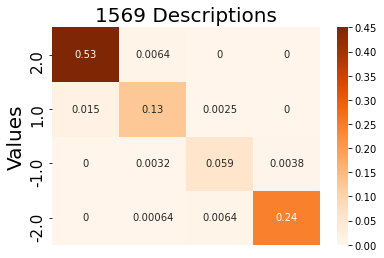

In [30]:
def heatmap_descriptions(to_plot_messages, title="", vmax=None):
    
    descriptions = to_plot_messages[~to_plot_messages.instruction]
    if len(descriptions) == 0:
        print("{}: found 0 descriptions.".format(to_plot_messages.workerid.unique()))
        return
              
    to_plot_messages = descriptions
        
    percent_of_messages = (to_plot_messages.groupby(["feature", "feature_value"]).size() / len(to_plot_messages)).reset_index()

    unique_values = set(percent_of_messages.feature_value.unique())
    missing_vals = unique_values.symmetric_difference({-2, -1, 1, 2})
    
    if missing_vals:
        print("Message with val {} not found-- appending.".format(missing_vals))
        for val in missing_vals:
            percent_of_messages = percent_of_messages.append({"feature": "Blue", "feature_value": val}, ignore_index=True)
    
    message_table = percent_of_messages.pivot("feature_value", "feature", 0)

    features_in_descending_order = ["Green", "Spotted", "Striped", "Blue"]
    message_table = message_table.reindex(features_in_descending_order, axis=1).fillna(0)
    
    plt.figure()
    ax = sns.heatmap(message_table, cmap="Oranges", vmax=vmax, annot=True)
    ax.invert_yaxis()
    ax.set_title("{} Descriptions".format(len(to_plot_messages)), fontsize=20)
#     ax.set_xticks([])
#     ax.set_yticks([])
    ax.set_xlabel("Features")
    ax.set_ylabel("Values")
    
heatmap_descriptions(exp1_trials, vmax=.45)#, annot=True)
plt.yticks(fontsize=15)
plt.ylabel("Values", fontsize=20)
plt.xticks([])
plt.xlabel("")

In [31]:
instructions = exp1_trials[exp1_trials.instruction]

instructions.groupby(["instruction_color", "instruction_texture"]).size()

instruction_color  instruction_texture
Blue               Solid                    4
                   Spotted                 16
                   Striped                  2
Green              Solid                  266
                   Spotted                514
                   Striped                152
Red                Solid                   83
                   Spotted                142
                   Striped                 24
dtype: int64

([], [])

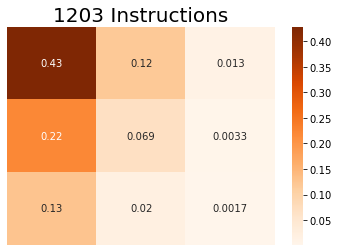

In [32]:
def heatmap_instructions(to_plot_messages, title="", vmax=None):
    
    instructions = to_plot_messages[to_plot_messages.instruction]
    if len(instructions) == 0:
        print("{}: found 0 descriptions.".format(to_plot_messages.workerid.unique()))
        return
              
    to_plot_messages = instructions
        
    percent_of_messages = (to_plot_messages.groupby(["instruction_color", "instruction_texture"]).size() / len(to_plot_messages)).reset_index()

    message_table = percent_of_messages.pivot("instruction_texture", "instruction_color", 0)

    color_order = ["Green", "Red",  "Blue"]
    texture_order = ["Spotted", "Solid", "Striped"]

    message_table = message_table.reindex(color_order, axis=1).fillna(0)
    message_table = message_table.reindex(texture_order, axis=0).fillna(0)
    
    plt.figure()
    ax = sns.heatmap(message_table, cmap="Oranges", annot=True)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
title = "{} Instructions".format(len(instructions))

heatmap_instructions(instructions, title=title, vmax=.45)
plt.xticks([])
plt.yticks([])

## Export for R

In [33]:
def utterance_to_string(utt):
    if utt['texture'] != '':
        return f'{utt["texture"]} {utt["color"]}'
    else:
        return f'{utt["feature"]} {utt["feature_value"]}'

exp1_trials['utterance_for_r'] = exp1_trials.utterance.apply(lambda x: utterance_to_string(x))

In [34]:
exp1_trials[['horizon', 'utterance_for_r']].to_csv("utterance_counts_for_r.csv")

In [35]:
exp1_trials.horizon.value_counts()

1    939
2    917
4    916
Name: horizon, dtype: int64

In [36]:
exp1_trials["utt"] = exp1_trials.data.apply(lambda x: x.get('response'))

In [37]:
exp_to_theory_map = {"Blue": "blue", "Green": "green", "Red": "red",
                     "Spotted": "circle", "Solid": "triangle", "Striped": "square"}

def extract_single_action_trials(trial):
    
    action_context = trial["data"]["action_context"][0]
    context = [{"color": exp_to_theory_map[a["color"]], "shape": exp_to_theory_map[a["texture"]]} for a in action_context]
    
    base = {"action_context": context,
            "workerid": trial["workerid"],
            "horizon": trial["horizon"]}
    
    utt = {}
    
    if trial["instruction"]:
        utt["color"] = exp_to_theory_map[trial["instruction_color"]]
        utt["shape"] = exp_to_theory_map[trial["instruction_texture"]]
        utt["type"] = "instruction"
    
    elif not trial["instruction"]:
        utt["type"] = "description"
        utt["feature"] = exp_to_theory_map[trial["feature"]]
        utt["value"] = int(trial["feature_value"])
    base["utt"] = utt
    return base

In [38]:
results = exp1_trials.apply(lambda x: extract_single_action_trials(x), axis=1)

In [39]:
json.dump(list(results.values), open("data/exp_utterances.json", "w"))